## 데이터 전처리

### 수치형
사상자수, 사망자수, 중상자수, 경상자수, 부상신고자수

### 범주형
주야, 요일, 발생지시도, 발생지시군구, 
사고유형_대분류, 사고유형_중분류, 법규위반, 도로형태_대분류,
도로형태, 당사자종별_1당_대분류, 당사자종별_2당_대분류

In [1]:
import pandas as pd
import numpy as np
from sklearn.preprocessing import LabelEncoder, LabelBinarizer, OneHotEncoder, MultiLabelBinarizer

In [2]:
categorical = ['주야', '요일', '발생지시도', '발생지시군구', '사고유형_대분류', '사고유형_중분류', '법규위반', 
            '도로형태_대분류', '도로형태', '당사자종별_1당_대분류', '당사자종별_2당_대분류']
numerical = ['사상자수', '사망자수', '중상자수', '경상자수','부상신고자수']
x_train_num = pd.read_csv('./교통사망사고정보/Kor_Train_교통사망사고정보(12.1~17.6).csv',encoding='cp949', 
                              usecols=numerical)

x_train_cat = pd.read_csv('./교통사망사고정보/Kor_Train_교통사망사고정보(12.1~17.6).csv',encoding='cp949',
                               usecols=categorical)


In [3]:
x_test_num = pd.read_csv('./test_kor.csv',encoding='cp949', 
                              usecols=numerical)

x_test_cat = pd.read_csv('./test_kor.csv',encoding='cp949',
                               usecols=categorical)

In [4]:
x_train_num.describe()

,사망자수,사상자수,중상자수,경상자수,부상신고자수
count,25037.000000,25037.00000,25037.000000,25037.000000,25037.000000
mean,1.040899,1.62152,0.299996,0.250509,0.030115
std,0.252493,2.05103,1.052157,1.145349,0.541728
min,1.000000,1.00000,0.000000,0.000000,0.000000
25%,1.000000,1.00000,0.000000,0.000000,0.000000
50%,1.000000,1.00000,0.000000,0.000000,0.000000
75%,1.000000,2.00000,0.000000,0.000000,0.000000
max,10.000000,100.00000,54.000000,62.000000,67.000000


In [5]:
x_train_cat.describe()

,주야,요일,발생지시도,발생지시군구,사고유형_대분류,사고유형_중분류,법규위반,도로형태_대분류,도로형태,당사자종별_1당_대분류,당사자종별_2당_대분류
count,25037,25037,25037,25037,25037,25037,25037,25037,25037,25037,25037
unique,2,7,17,208,4,19,20,9,16,12,14
top,야간,금,경기,서구,차대차,기타,안전운전 의무 불이행,단일로,기타단일로,승용차,보행자
freq,12913,3714,4728,493,9857,5847,17741,16746,15011,12374,9784


In [6]:
x_test_num.describe()

,사망자수,사상자수,중상자수,경상자수,부상신고자수
count,41.000000,33.000000,36.000000,42.000000,48.000000
mean,1.170732,3.636364,0.833333,1.785714,0.312500
std,0.380949,4.181942,1.715476,4.027562,1.545842
min,1.000000,1.000000,0.000000,0.000000,0.000000
25%,1.000000,1.000000,0.000000,0.000000,0.000000
50%,1.000000,2.000000,0.000000,0.000000,0.000000
75%,1.000000,4.000000,1.000000,1.000000,0.000000
max,2.000000,19.000000,9.000000,21.000000,10.000000


In [7]:
x_test_cat.describe()

,주야,요일,발생지시도,발생지시군구,사고유형_대분류,사고유형_중분류,법규위반,도로형태_대분류,도로형태,당사자종별_1당_대분류,당사자종별_2당_대분류
count,45,45,45,40,38,35,37,37,37,41,43
unique,2,7,14,37,3,9,8,2,5,8,8
top,주간,화,경기,평택시,차대차,추돌,안전운전 의무 불이행,단일로,기타단일로,승용차,화물차
freq,24,12,8,3,25,11,22,24,24,19,11


### One Hot Encdoing을 나열해서 만드는 방법

In [8]:
all_data = pd.concat((x_test_cat.dropna(),x_train_cat))
for col in all_data.select_dtypes(include=[np.object]).columns:
    print(col, all_data[col].unique())

주야 ['야간' '주간']
요일 ['금' '월' '일' '목' '수' '화' '토']
발생지시도 ['경기' '전남' '대구' '경북' '충남' '강원' '충북' '서울' '광주' '부산' '경남' '인천' '세종' '전북'
 '대전' '울산' '제주']
발생지시군구 ['화성시' '영암군' '곡성군' '달성군' '고흥군' '영천시' '아산시' '서천군' '평창군' '음성군' '성남시' '서산시'
 '서구' '영등포구' '용인시' '광양시' '광산구' '중구' '원주시' '고양시' '논산시' '동구' '고성군' '안산시'
 '목포시' '강서구' '시흥시' '이천시' '사상구' '광진구' '서대문구' '양평군' '남양주시' '동작구' '기장군' '예산군'
 '남구' '여수시' '제천시' '세종' '춘천시' '의성군' '충주시' '서초구' '금산군' '밀양시' '김천시' '군산시'
 '대덕구' '파주시' '진주시' '김해시' '북구' '나주시' '고창군' '합천군' '무주군' '계양구' '함양군' '안동시'
 '인제군' '사하구' '철원군' '강동구' '홍성군' '안양시' '정선군' '용산구' '구미시' '부산진구' '광명시' '송파구'
 '평택시' '남원시' '함안군' '서귀포시' '경산시' '정읍시' '청주시' '상주시' '삼척시' '강릉시' '양산시' '제주시'
 '달서구' '영덕군' '여주시' '장성군' '전주시' '청도군' '포항시' '마포구' '영광군' '영주시' '도봉구' '당진시'
 '부천시' '수성구' '봉화군' '익산시' '구로구' '유성구' '금천구' '천안시' '진도군' '가평군' '강화군' '거창군'
 '군위군' '부평구' '양주시' '사천시' '의정부시' '영동군' '광주시' '창원시(통합)' '울주군' '진천군' '김포시'
 '동래구' '강남구' '보령시' '강진군' '보성군' '화순군' '순천시' '보은군' '양양군' '군포시' '청송군' '통영시'
 '수원시' '경주시' '하남시' '완주군' '양천구' '함평군' '의령군' '공주시' '

In [9]:
for column in all_data.select_dtypes(include=[np.object]).columns:
    x_train_cat[column] = x_train_cat[column].astype('category', categories = all_data[column].unique())
    x_test_cat[column] = x_test_cat[column].astype('category', categories = all_data[column].unique())

/home/iron/.local/lib/python3.5/site-packages/ipykernel_launcher.py:2: FutureWarning: specifying 'categories' or 'ordered' in .astype() is deprecated; pass a CategoricalDtype instead
  
/home/iron/.local/lib/python3.5/site-packages/ipykernel_launcher.py:3: FutureWarning: specifying 'categories' or 'ordered' in .astype() is deprecated; pass a CategoricalDtype instead
  This is separate from the ipykernel package so we can avoid doing imports until


In [10]:
x_train_cat = pd.get_dummies(data=x_train_cat)
x_test_cat = pd.get_dummies(data=x_test_cat)

In [11]:
print(x_train_cat.shape)
print(x_test_cat.shape)

(25037, 328)
(50, 328)


# Deep Learning

In [12]:
import keras
from keras.layers import Dense, Input, LSTM, concatenate, Dropout, Conv2D, MaxPool2D, Embedding, Reshape
from keras.models import Sequential, Model
from keras.utils import np_utils
from keras.callbacks import ReduceLROnPlateau, ModelCheckpoint, EarlyStopping
from keras import metrics

Using TensorFlow backend.


In [13]:
print(x_train_cat.shape)
print(x_train_num.shape)
print(x_test_cat.shape)
print(x_test_num.shape)

(25037, 328)
(25037, 5)
(50, 328)
(50, 5)


In [14]:
Case1 = ['사망자수','사상자수','경상자수']
Case2 = ['사상자수', '중상자수', '부상신고자수']

### Case 1
'사망자수','사상자수','경상자수' 예측

In [79]:
Y = x_train_num[['사망자수','경상자수']].values
X = x_train_num.drop(columns=['사망자수','사상자수','경상자수'])

In [80]:
print(X.index)
print(x_train_cat.index)
if X.index.all() == x_train_cat.index.all():
    print(True)
else:
    print(False)

RangeIndex(start=0, stop=25037, step=1)
RangeIndex(start=0, stop=25037, step=1)
True


In [81]:
# X = X.reset_index(drop=True)
# x_train_cat = x_train_cat.reset_index(drop=True)

In [82]:
X = pd.concat([X, x_train_cat], axis=1).values

In [83]:
X.shape

(25037, 330)

Test Data 생성

In [84]:
X_test = x_test_num.drop(columns=['사망자수','사상자수','경상자수'])
# X_test = X_test.reset_index(drop=True)
# x_test_cat = x_test_cat.reset_index(drop=True)
X_test = pd.concat([X_test, x_test_cat],axis=1).values

In [85]:
print(X.shape)
print(Y.shape)

(25037, 330)
(25037, 2)


In [86]:
num_input = Input(shape=(len(X[0]),), name='num_input')
x = Dense(512, activation='relu')(num_input)
x = Dropout(0.3)(x)
x = Dense(512, activation='relu')(x)
x = Dropout(0.3)(x)
x = Dense(512, activation='relu')(x)
x = Dropout(0.3)(x)
x = Dense(512, activation='relu')(x)
x = Dropout(0.3)(x)
num_output = Dense(len(Y[0]), name='num_output')(x)

In [87]:
model = Model(inputs=num_input, outputs=num_output)

In [88]:
model.compile(optimizer='sgd',
              loss='mse',
              metrics=['accuracy'])

In [89]:
learning_rate_reduction = ReduceLROnPlateau(monitor='val_acc', 
                                            patience=25, 
                                            verbose=1, 
                                            factor=0.5, 
                                            min_lr=0.00000001)

callbacks = [
    learning_rate_reduction, # learning_rate를 점차 감소시킴으로서 최적값에 접근하는 방식
                                        # approach to get optimal value by gradually decreasing learning_rate
    EarlyStopping('val_loss', patience=10), # val_loss이 최적값에서 멀어지는 순간 epoch가 남아도 학습 중지
                                                            # If val_loss deviates from the optimal value, 
                                                            # learning stops even if epoch remains.
    ModelCheckpoint('model.h5', save_best_only=True)] # 모델을 학습시키면서 지금까지 등장했던 최적의 weight들을 항상 저장한다.

In [90]:
history = model.fit(X, Y, epochs=50, batch_size=128, callbacks=callbacks,validation_split=0.2 )

Train on 20029 samples, validate on 5008 samples
Epoch 1/50
20029/20029 [==============================] - 1s 43us/step - loss: 0.7141 - acc: 0.9326 - val_loss: 0.6196 - val_acc: 0.9557
Epoch 2/50
20029/20029 [==============================] - 1s 28us/step - loss: 0.6220 - acc: 0.9554 - val_loss: 0.5763 - val_acc: 0.9405
Epoch 3/50
20029/20029 [==============================] - 1s 28us/step - loss: 0.6033 - acc: 0.9492 - val_loss: 0.5658 - val_acc: 0.9383
Epoch 4/50
20029/20029 [==============================] - 1s 28us/step - loss: 0.6169 - acc: 0.9471 - val_loss: 0.5683 - val_acc: 0.9401
Epoch 5/50
20029/20029 [==============================] - 1s 28us/step - loss: 0.5962 - acc: 0.9480 - val_loss: 0.5575 - val_acc: 0.9391
Epoch 6/50
20029/20029 [==============================] - 1s 27us/step - loss: 0.5949 - acc: 0.9454 - val_loss: 0.5547 - val_acc: 0.9393
Epoch 7/50
20029/20029 [==============================] - 1s 28us/step - loss: 0.5896 - acc: 0.9474 - val_loss: 0.5464 - val_acc:

In [91]:
# make a prediction
Y_test = model.predict(X_test[0:2])
# Y_test = model.predict(X[0:2])

# show the inputs and predicted outputs
print("X=%s, Predicted=%s" % (X_test[0:2],  Y_test ))

X=[[0. 0. 1. 0. 1. 0. 0. 0. 0. 0. 0. 1. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
  0. 0. 0. 0. 1. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
  0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
  0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
  0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
  0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
  0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
  0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
  0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
  0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 1. 0. 0. 0.
  1. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 1. 0. 0. 0. 0.
  0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 1. 0. 0. 0. 0. 0. 0. 0. 0.
  1. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 1. 0. 0. 0. 0. 0. 0. 0.
  0. 0. 0. 0. 1. 0. 0. 0. 0. 0. 0. 0

### Case 2

'사상자수', '중상자수', '부상신고자수' 예측

In [219]:
Y = x_train_num[['사상자수', '중상자수', '부상신고자수']].values
X = x_train_num.drop(columns=['사상자수', '중상자수', '부상신고자수'])

In [220]:
X = X.reset_index(drop=True)
x_train_cat = x_train_cat.reset_index(drop=True)

In [221]:
X = pd.concat([X, x_train_cat], axis=1).values

Test Data 생성

In [222]:
X_test = x_test_num.drop(columns=['사상자수', '중상자수', '부상신고자수'])
X_test = X_test.reset_index(drop=True)
x_test_cat = x_test_cat.reset_index(drop=True)
X_test = pd.concat([X_test, x_test_cat],axis=1).values

In [231]:
X_test

array([[nan, nan,  1., ...,  0.,  0.,  0.],
       [nan, nan,  1., ...,  0.,  0.,  0.],
       [ 1.,  0.,  1., ...,  0.,  0.,  0.],
       ...,
       [ 1.,  0.,  0., ...,  0.,  0.,  0.],
       [ 2.,  9.,  0., ...,  0.,  0.,  0.],
       [ 1.,  0.,  0., ...,  0.,  0.,  0.]])

In [223]:
print(X.shape)
print(Y.shape)

(25037, 330)
(25037, 3)


In [242]:
num_input = Input(shape=(len(X[0]),), name='num_input')
x = Dense(512, activation='relu')(num_input)
x = Dropout(0.3)(x)
x = Dense(512, activation='relu')(x)
x = Dropout(0.3)(x)
x = Dense(512, activation='relu')(x)
x = Dropout(0.3)(x)
x = Dense(512, activation='relu')(x)
x = Dropout(0.3)(x)
num_output = Dense(len(Y[0]), name='num_output')(x)

In [243]:
model = Model(inputs=num_input, outputs=num_output)

In [244]:
model.compile(optimizer='sgd',
              loss='mse',
              metrics=['accuracy'])

In [245]:
learning_rate_reduction = ReduceLROnPlateau(monitor='val_acc', 
                                            patience=25, 
                                            verbose=1, 
                                            factor=0.5, 
                                            min_lr=0.00000001)

callbacks = [
    learning_rate_reduction, # learning_rate를 점차 감소시킴으로서 최적값에 접근하는 방식
                                        # approach to get optimal value by gradually decreasing learning_rate
    EarlyStopping('val_loss', patience=10), # val_loss이 최적값에서 멀어지는 순간 epoch가 남아도 학습 중지
                                                            # If val_loss deviates from the optimal value, 
                                                            # learning stops even if epoch remains.
    ModelCheckpoint('model.h5', save_best_only=True)] # 모델을 학습시키면서 지금까지 등장했던 최적의 weight들을 항상 저장한다.

In [246]:
history = model.fit(X, Y, epochs=50, batch_size=128, callbacks=callbacks,validation_split=0.2 )

Train on 20029 samples, validate on 5008 samples
Epoch 1/50
20029/20029 [==============================] - 1s 37us/step - loss: 1.1353 - acc: 0.9906 - val_loss: 1.3231 - val_acc: 1.0000
Epoch 2/50
20029/20029 [==============================] - 1s 27us/step - loss: 0.9941 - acc: 1.0000 - val_loss: 1.5311 - val_acc: 1.0000
Epoch 3/50
20029/20029 [==============================] - 1s 28us/step - loss: 0.8412 - acc: 1.0000 - val_loss: 1.2721 - val_acc: 1.0000
Epoch 4/50
20029/20029 [==============================] - 1s 28us/step - loss: 0.7906 - acc: 1.0000 - val_loss: 1.5489 - val_acc: 1.0000
Epoch 5/50
20029/20029 [==============================] - 1s 27us/step - loss: 0.8055 - acc: 1.0000 - val_loss: 1.2552 - val_acc: 1.0000
Epoch 6/50
20029/20029 [==============================] - 1s 27us/step - loss: 0.7961 - acc: 1.0000 - val_loss: 1.2185 - val_acc: 1.0000
Epoch 7/50
20029/20029 [==============================] - 1s 27us/step - loss: 0.8144 - acc: 1.0000 - val_loss: 1.1873 - val_acc:

In [247]:
# make a prediction
Y_test = model.predict(X_test[2:4])
# Y_test = model.predict(X[0:2])

# show the inputs and predicted outputs
print("X=%s, Predicted=%s" % (X_test[2:4],  Y_test ))

X=[[1. 0. 1. 0. 0. 1. 0. 0. 0. 0. 0. 0. 1. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
  0. 0. 0. 0. 0. 0. 1. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
  0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
  0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
  0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
  0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
  0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
  0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
  0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
  0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 1. 0.
  0. 0. 1. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 1. 0. 0.
  0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 1. 0. 0. 0. 0. 0. 0. 0. 0.
  1. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 1. 0. 0. 0. 0. 0. 0.
  0. 0. 0. 0. 0. 0. 1. 0. 0. 0. 0. 0

### Case 3
'사상자수', '중상자수', '경상자수' 예측

In [34]:
Y = x_train_num[['사상자수', '중상자수', '경상자수']].values
X = x_train_num.drop(columns=['사상자수', '중상자수', '경상자수'])

In [35]:
X = pd.concat([X, x_train_cat], axis=1).values

Test Data 생성

In [36]:
X_test = x_test_num.drop(columns=['사상자수', '중상자수', '경상자수'])
X_test = pd.concat([X_test, x_test_cat],axis=1).values

In [37]:
print(X.shape)
print(Y.shape)

(25037, 330)
(25037, 3)


In [38]:
num_input = Input(shape=(len(X[0]),), name='num_input')
x = Dense(512, activation='relu')(num_input)
x = Dropout(0.3)(x)
x = Dense(512, activation='relu')(x)
x = Dropout(0.3)(x)
x = Dense(512, activation='relu')(x)
x = Dropout(0.3)(x)
x = Dense(512, activation='relu')(x)
x = Dropout(0.3)(x)
num_output = Dense(len(Y[0]), name='num_output')(x)

In [39]:
model = Model(inputs=num_input, outputs=num_output)

In [40]:
model.compile(optimizer='sgd',
              loss='mse',
              metrics=['accuracy'])

In [41]:
learning_rate_reduction = ReduceLROnPlateau(monitor='val_acc', 
                                            patience=25, 
                                            verbose=1, 
                                            factor=0.5, 
                                            min_lr=0.00000001)

callbacks = [
    learning_rate_reduction, # learning_rate를 점차 감소시킴으로서 최적값에 접근하는 방식
                                        # approach to get optimal value by gradually decreasing learning_rate
    EarlyStopping('val_loss', patience=10), # val_loss이 최적값에서 멀어지는 순간 epoch가 남아도 학습 중지
                                                            # If val_loss deviates from the optimal value, 
                                                            # learning stops even if epoch remains.
    ModelCheckpoint('model.h5', save_best_only=True)] # 모델을 학습시키면서 지금까지 등장했던 최적의 weight들을 항상 저장한다.

In [42]:
history = model.fit(X, Y, epochs=50, batch_size=128, callbacks=callbacks,validation_split=0.2 )

Train on 20029 samples, validate on 5008 samples
Epoch 1/50
20029/20029 [==============================] - 1s 36us/step - loss: 2.1094 - acc: 0.9922 - val_loss: 2.1658 - val_acc: 1.0000
Epoch 2/50
20029/20029 [==============================] - 1s 28us/step - loss: 1.8946 - acc: 1.0000 - val_loss: 1.8385 - val_acc: 1.0000
Epoch 3/50
20029/20029 [==============================] - 1s 27us/step - loss: 1.8123 - acc: 1.0000 - val_loss: 1.8323 - val_acc: 1.0000
Epoch 4/50
20029/20029 [==============================] - 1s 27us/step - loss: 1.7215 - acc: 1.0000 - val_loss: 1.7207 - val_acc: 1.0000
Epoch 5/50
20029/20029 [==============================] - 1s 27us/step - loss: 1.6523 - acc: 1.0000 - val_loss: 1.7731 - val_acc: 1.0000
Epoch 6/50
20029/20029 [==============================] - 1s 27us/step - loss: 1.6442 - acc: 1.0000 - val_loss: 1.5930 - val_acc: 1.0000
Epoch 7/50
20029/20029 [==============================] - 1s 30us/step - loss: 1.5781 - acc: 1.0000 - val_loss: 1.6481 - val_acc:

In [43]:
# make a prediction
Y_test = model.predict(X_test[4:7])

# show the inputs and predicted outputs
print("X=%s, Predicted=%s" % (X_test[4:7],  Y_test ))

X=[[1. 0. 0. 1. 0. 0. 0. 1. 0. 0. 0. 0. 1. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
  0. 0. 0. 0. 0. 0. 0. 0. 1. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
  0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
  0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
  0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
  0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
  0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
  0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
  0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
  0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 1. 0. 0. 0.
  0. 0. 0. 1. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 1. 0. 0. 0. 0.
  0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 1. 0. 0. 0. 0. 0. 0. 0. 0.
  1. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 1. 0. 0. 0. 0. 0.
  0. 0. 0. 0. 0. 0. 0. 1. 0. 0. 0. 0

### Case 4
'사망자수', '사상자수', '중상자수' 예측

In [67]:
Y = x_train_num[['사망자수', '중상자수']].values
X = x_train_num.drop(columns=['사망자수', '사상자수', '중상자수'])

In [68]:
X = pd.concat([X, x_train_cat], axis=1).values

Test Data 생성

In [77]:
X_test = x_test_num.drop(columns=['사망자수', '사상자수', '중상자수'])
X_test = pd.concat([X_test, x_test_cat],axis=1).values

In [70]:
print(X.shape)
print(Y.shape)

(25037, 330)
(25037, 2)


In [71]:
num_input = Input(shape=(len(X[0]),), name='num_input')
x = Dense(512, activation='relu')(num_input)
x = Dropout(0.3)(x)
x = Dense(512, activation='relu')(x)
x = Dropout(0.3)(x)
x = Dense(512, activation='relu')(x)
x = Dropout(0.3)(x)
x = Dense(256, activation='relu')(x)
x = Dropout(0.3)(x)
num_output = Dense(len(Y[0]), name='num_output')(x)

In [72]:
model = Model(inputs=num_input, outputs=num_output)

In [73]:
model.compile(optimizer='adam',
              loss='mse',
              metrics=['accuracy'])

In [74]:
learning_rate_reduction = ReduceLROnPlateau(monitor='val_acc', 
                                            patience=25, 
                                            verbose=1, 
                                            factor=0.5, 
                                            min_lr=0.00000001)

callbacks = [
    learning_rate_reduction, # learning_rate를 점차 감소시킴으로서 최적값에 접근하는 방식
                                        # approach to get optimal value by gradually decreasing learning_rate
    EarlyStopping('val_loss', patience=10), # val_loss이 최적값에서 멀어지는 순간 epoch가 남아도 학습 중지
                                                            # If val_loss deviates from the optimal value, 
                                                            # learning stops even if epoch remains.
    ModelCheckpoint('model.h5', save_best_only=True)] # 모델을 학습시키면서 지금까지 등장했던 최적의 weight들을 항상 저장한다.

In [75]:
history = model.fit(X, Y, epochs=50, batch_size=128, callbacks=callbacks,validation_split=0.2 )

Train on 20029 samples, validate on 5008 samples
Epoch 1/50
20029/20029 [==============================] - 1s 52us/step - loss: 0.5541 - acc: 0.9251 - val_loss: 0.5070 - val_acc: 0.9303
Epoch 2/50
20029/20029 [==============================] - 1s 38us/step - loss: 0.4962 - acc: 0.9276 - val_loss: 0.4655 - val_acc: 0.9139
Epoch 3/50
20029/20029 [==============================] - 1s 35us/step - loss: 0.4760 - acc: 0.9297 - val_loss: 0.4747 - val_acc: 0.9119
Epoch 4/50
20029/20029 [==============================] - 1s 35us/step - loss: 0.4676 - acc: 0.9303 - val_loss: 0.4840 - val_acc: 0.9333
Epoch 5/50
20029/20029 [==============================] - 1s 35us/step - loss: 0.4243 - acc: 0.9336 - val_loss: 0.6673 - val_acc: 0.9247
Epoch 6/50
20029/20029 [==============================] - 1s 35us/step - loss: 0.4054 - acc: 0.9410 - val_loss: 0.6006 - val_acc: 0.9058
Epoch 7/50
20029/20029 [==============================] - 1s 38us/step - loss: 0.3551 - acc: 0.9414 - val_loss: 0.6155 - val_acc:

In [78]:
# make a prediction
Y_test = model.predict(X_test[7:10])

# show the inputs and predicted outputs
print("X=%s, Predicted=%s" % (X_test[7:10],  Y_test ))

X=[[ 5.  0.  0.  1.  0.  1.  0.  0.  0.  0.  0.  0.  0.  0.  0.  1.  0.  0.
   0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  1.
   0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.
   0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.
   0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.
   0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.
   0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.
   0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.
   0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.
   0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.
   0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.
   0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.
   0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.
   0.  0.  1.  0.  0.  0.  0.  0.  0

In [117]:
X[0]

array([0, 0, 1, 0, 1, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0,

In [524]:
x_test_cat_data = x_train_cat[25030:25034]
x_test_num_data = x_train_num[25030:25034]

In [463]:
x_train_cat = x_train_cat[:24960]
x_train_cat_data = x_train_cat.reshape(-1,4,11)

In [464]:
x_train_num = x_train_num[:24960]
x_train_num_data = x_train_num.reshape(-1,4,5)

In [654]:
print(x_train_cat_data.shape)
print(x_train_num_data.shape)

(6240, 4, 11)
(6240, 4, 5)


In [527]:
x_train_cat_data1 = np.expand_dims(x_train_cat_data, axis=0)
print(np.expand_dims(x_train_cat_data, axis=0).shape)

(1, 6240, 4, 11)


In [429]:
x_train_cat_data[0]

array([[ 0,  0,  1, 93,  1, 17, 10,  5,  8,  5,  2],
       [ 0,  0, 12, 19,  2, 14, 10,  5,  8,  5,  5],
       [ 0,  0, 15, 90,  1, 13, 10,  5,  8,  5,  2],
       [ 0,  0,  5, 87,  2, 16, 10,  2,  4,  5, 10]])

In [899]:
x_train_cat = x_train_cat[:25030]
x_train_cat1 = np.expand_dims(x_train_cat, axis=1)
print(x_train_cat1.shape)

(25030, 1, 329)


## Define Model

In [529]:
# cat_input = Input(shape=(329,), name='cat_input')
# print(cat_input)
# x = Reshape((1,329))(cat_input)
# print(x)
# x = LSTM(64, activation='relu', return_sequences=True)(x)
# x = Dropout(0.3)(x)
# x = LSTM(64, activation='relu', return_sequences=True)(x)
# x = Dropout(0.3)(x)
# x = LSTM(64, activation='relu', return_sequences=False)(x)
# x = Dropout(0.3)(x)
# x = Dense(64, activation='relu')(x)
# x = Dropout(0.3)(x)
# x = Dense(64, activation='relu')(x)
# x = Dropout(0.3)(x)
# cat_output = Dense(329, activation='softmax', name='cat_output')(x)

Tensor("cat_input_43:0", shape=(?, 329), dtype=float32)
Tensor("reshape_1/Reshape:0", shape=(?, 1, 329), dtype=float32)


In [726]:
cate_input = Input(shape=(11,), name='cate_input')
x = Reshape((1,11))(cate_input)
x = LSTM(64, activation='relu')(x)
x = Dropout(0.3)(x)
x = Dense(64, activation='relu')(x)
x = Dropout(0.3)(x)
num_input = Input(shape=(5,), name='num_input')
x = concatenate([x, num_input])
print(x)
x = Dense(64, activation='relu')(x)
x = Dropout(0.3)(x)
cate_output = Dense(11,  activation='relu', name='cate_output')(x)
# cate_output = Reshape((4,5),  name='cate_output')(x)

Tensor("concatenate_42/concat:0", shape=(?, 69), dtype=float32)


In [727]:
model = Model(inputs=[cate_input, num_input], outputs=[cate_output])

In [728]:
#categorical_crossentropy
model.compile(optimizer='sgd',
              loss={'cate_output':'mse'},
              metrics=['accuracy'])

In [729]:
learning_rate_reduction = ReduceLROnPlateau(monitor='val_acc', 
                                            patience=25, 
                                            verbose=1, 
                                            factor=0.5, 
                                            min_lr=0.00000001)

callbacks = [
    learning_rate_reduction, # learning_rate를 점차 감소시킴으로서 최적값에 접근하는 방식
                                        # approach to get optimal value by gradually decreasing learning_rate
    EarlyStopping('val_loss', patience=3), # val_loss이 최적값에서 멀어지는 순간 epoch가 남아도 학습 중지
                                                            # If val_loss deviates from the optimal value, 
                                                            # learning stops even if epoch remains.
    ModelCheckpoint('model.h5', save_best_only=True)] # 모델을 학습시키면서 지금까지 등장했던 최적의 weight들을 항상 저장한다.


hist = model.fit([x_train_cat, x_train_num], x_train_cat, epochs=50, batch_size=32, verbose=1, callbacks=callbacks, validation_split=0.2,)

Train on 19968 samples, validate on 4992 samples
Epoch 1/50
19968/19968 [==============================] - 6s 295us/step - loss: 6176.9618 - acc: 0.0015 - val_loss: 1370.4375 - val_acc: 0.0000e+00
Epoch 2/50
19968/19968 [==============================] - 3s 149us/step - loss: 1362.1600 - acc: 0.0000e+00 - val_loss: 1370.4375 - val_acc: 0.0000e+00
Epoch 3/50
19968/19968 [==============================] - 3s 147us/step - loss: 1362.1600 - acc: 0.0000e+00 - val_loss: 1370.4375 - val_acc: 0.0000e+00
Epoch 4/50
19968/19968 [==============================] - 3s 147us/step - loss: 1362.1600 - acc: 0.0000e+00 - val_loss: 1370.4375 - val_acc: 0.0000e+00


In [719]:
print(x_train_cat[19])
print(x_train_num[19])

[  1   1   1 109   1  17  10   2   5   6   2]
[1 8 0 7 0]


In [716]:
x_value = x_train_cat[20]
print(type(x_value))

<class 'numpy.ndarray'>


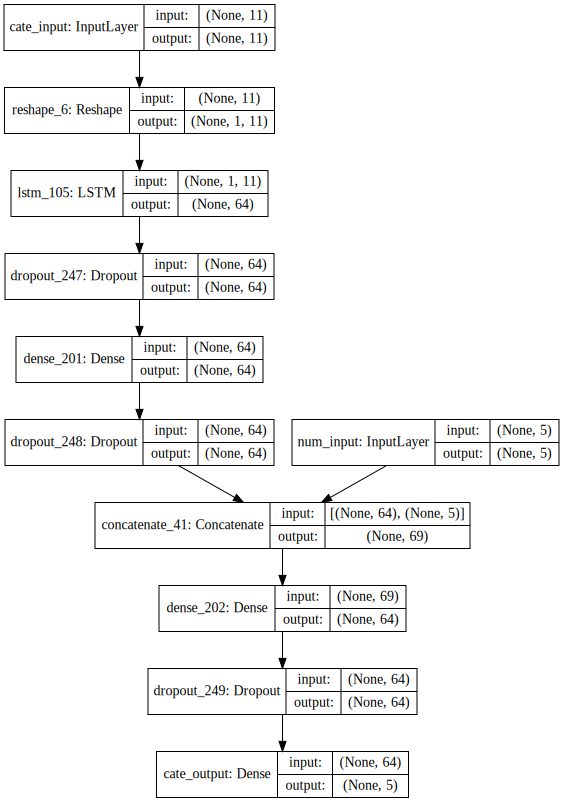

In [706]:
from IPython.display import SVG
from keras.utils.vis_utils import model_to_dot

%matplotlib inline

SVG(model_to_dot(model, show_shapes=True).create(prog='dot', format='svg'))

In [721]:
Xnew2 = np.array([x_train_cat[19]])

Xnew1 = np.array([x_train_num[19]])


# make a prediction
ynew = model.predict({'cate_input':Xnew2,'num_input':Xnew1})

# show the inputs and predicted outputs
print("X=%s, Predicted=%s" % (Xnew1[0],  ynew ))

X=[1 8 0 7 0], Predicted=[[0.86509156 7.7890024  0.33240092 6.5731373  0.        ]]


## 예전에 사용한 모델 데이터들

In [259]:
model = Model(inputs=[num_input, cat_input], outputs=[num_output, cat_output])

In [260]:
model.compile(optimizer='rmsprop',
              loss={'num_output':'mse', 'cat_output':'categorical_crossentropy'},
              metrics=['accuracy'])

In [261]:
learning_rate_reduction = ReduceLROnPlateau(monitor='val_acc', 
                                            patience=2, 
                                            verbose=1, 
                                            factor=0.5, 
                                            min_lr=0.00000001)

callbacks = [
    learning_rate_reduction, # learning_rate를 점차 감소시킴으로서 최적값에 접근하는 방식
                                        # approach to get optimal value by gradually decreasing learning_rate
    EarlyStopping('val_loss', patience=3), # val_loss이 최적값에서 멀어지는 순간 epoch가 남아도 학습 중지
                                                            # If val_loss deviates from the optimal value, 
                                                            # learning stops even if epoch remains.
    ModelCheckpoint('model.h5', save_best_only=True)] # 모델을 학습시키면서 지금까지 등장했던 최적의 weight들을 항상 저장한다.


hist = model.fit({'num_input':x_train_num, 'cat_input':x_train_cat}, {'num_output': y_train_num, 'cat_output':x_train_cat}, epochs=50, batch_size=64, callbacks=callbacks, validation_split=0.1,)

Train on 22533 samples, validate on 2504 samples
Epoch 1/50
22533/22533 [==============================] - 1s 64us/step - loss: 399.6520 - num_output_loss: 0.2217 - cat_output_loss: 399.4303 - num_output_acc: 0.6617 - cat_output_acc: 0.9598 - val_loss: 380.0138 - val_num_output_loss: 0.0705 - val_cat_output_loss: 379.9433 - val_num_output_acc: 1.0000 - val_cat_output_acc: 0.9800


/usr/local/lib/python3.5/dist-packages/keras/callbacks.py:1043: RuntimeWarning: Reduce LR on plateau conditioned on metric `val_acc` which is not available. Available metrics are: loss,val_cat_output_acc,num_output_loss,cat_output_loss,val_loss,val_cat_output_loss,val_num_output_loss,lr,cat_output_acc,val_num_output_acc,num_output_acc
  (self.monitor, ','.join(list(logs.keys()))), RuntimeWarning


Epoch 2/50
22533/22533 [==============================] - 1s 49us/step - loss: 347.3038 - num_output_loss: 0.0906 - cat_output_loss: 347.2132 - num_output_acc: 0.6040 - cat_output_acc: 0.9814 - val_loss: 341.4980 - val_num_output_loss: 0.1200 - val_cat_output_loss: 341.3780 - val_num_output_acc: 1.0000 - val_cat_output_acc: 0.9800
Epoch 3/50
22533/22533 [==============================] - 1s 52us/step - loss: 329.4858 - num_output_loss: 0.0844 - cat_output_loss: 329.4014 - num_output_acc: 0.7987 - cat_output_acc: 0.9824 - val_loss: 332.0796 - val_num_output_loss: 0.0784 - val_cat_output_loss: 332.0012 - val_num_output_acc: 0.2716 - val_cat_output_acc: 0.9856
Epoch 4/50
22533/22533 [==============================] - 1s 51us/step - loss: 315.3419 - num_output_loss: 0.0825 - cat_output_loss: 315.2594 - num_output_acc: 0.8714 - cat_output_acc: 0.9835 - val_loss: 312.8341 - val_num_output_loss: 0.3030 - val_cat_output_loss: 312.5311 - val_num_output_acc: 0.2716 - val_cat_output_acc: 0.9768
E

In [262]:
loss_and_metrics = model.evaluate({'num_input':x_train_num, 'cat_input':x_train_cat}, {'num_output': y_train_num, 'cat_output':x_train_cat}, batch_size=32)
print(loss_and_metrics)
print(loss_and_metrics[0])
print(loss_and_metrics[1] * 100)

25037/25037 [==============================] - 1s 39us/step
[307.81578775862897, 0.07099316146763511, 307.74479453636155, 1.0, 0.990094659903343]
307.81578775862897
7.099316146763511


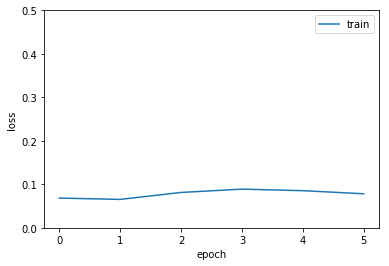

In [723]:
%matplotlib inline
import matplotlib.pyplot as plt

plt.plot(hist.history['loss'])
plt.ylim(0.0, 0.5)
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train'], loc='upper right')
plt.show()